# Multi classifier

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

In [148]:
df_large = pd.read_csv('input/complaints.csv')
df = df_large[:5000]
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-03-06,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,27105,NaN,Consent not provided,Web,2020-03-06,Closed with explanation,Yes,NaN,3556830
1,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
2,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
3,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
4,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198


## todo
- remove all cells except complaint and product
- remove missing values in narrative
- add column encoding product as integer

In [149]:
df.drop(['Date received', 'Sub-product', 'Issue', 'Sub-issue', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID'], axis = 1, inplace = True)

/mnt/sdb1/nora/git/text-classifier/venv/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [150]:
df.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,Debt collection,transworld systems inc. \nis trying to collect...
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
4,Debt collection,"Over the past 2 weeks, I have been receiving e..."


In [151]:
df = df[pd.notnull(df['Consumer complaint narrative'])]
df['category_id'] = df['Product'].factorize()[0]

In [152]:
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [153]:
df.head()

,Product,Consumer complaint narrative,category_id
1,Debt collection,transworld systems inc. \nis trying to collect...,0
3,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,1
4,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
10,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",2
11,Debt collection,While checking my credit report I noticed thre...,0


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 1 to 4995
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       1101 non-null   object
 1   Consumer complaint narrative  1101 non-null   object
 2   category_id                   1101 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 34.4+ KB


Text(0, 0.5, 'Complaint Count')

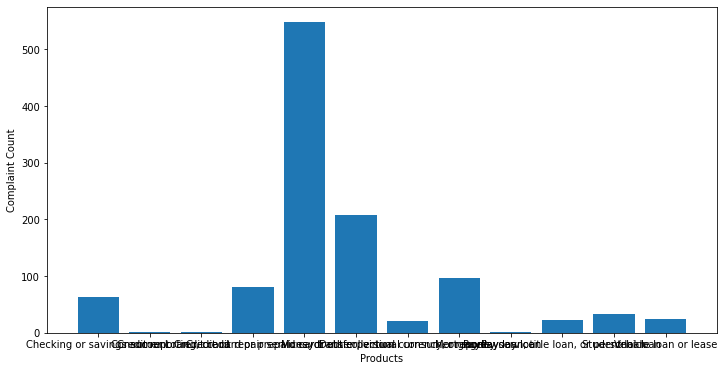

In [155]:
product_distribution = df.groupby('Product').count()
fig = plt.figure(figsize=(12,6))
plt.bar(product_distribution.index.values, product_distribution['Consumer complaint narrative'])
plt.xlabel('Products')
plt.ylabel('Complaint Count')


In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# !export CUDA_VISIBLE_DEVICES=1



- in min 5 documents a word has to be to be kept
- norm ?
- ngram range ?


In [157]:
tf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')



features = tf.fit_transform(df['Consumer complaint narrative']).toarray()
labels = df.category_id
features.shape

(1101, 4215)

In [158]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2

for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Checking or savings account':
  . Most correlated unigrams:
. overdraft
. checking
  . Most correlated bigrams:
. savings account
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. list
. conversation
  . Most correlated bigrams:
. midwest recovery
. loan application
# 'Credit card':
  . Most correlated unigrams:
. debited
. voice
  . Most correlated bigrams:
. immediately called
. receive phone
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. capital
. card
  . Most correlated bigrams:
. annual fee
. credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. equifax
. reporting
  . Most correlated bigrams:
. credit reporting
. credit report
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collect debt
. debt collection
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
. wire
. paypal
  . Most c

In [159]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Consumer complaint narrative'], df['category_id'], test_size=0.3 )

In [160]:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [161]:
print(clf.predict(count_vect.transform(["While checking my credit report I noticed three collections by a company called ARS that i was unfamiliar with. I disputed these collections with XXXX, and XXXX and they both replied that they contacted the creditor and the creditor verified the debt so I asked for proof which both bureaus replied that they are not required to prove anything. I then mailed a certified letter to ARS requesting proof of the debts n the form of an original aggrement, or a proof of a right to the debt, or even so much as the process as to how the bill was calculated, to which I was simply replied a letter for each collection claim that listed my name an account number and an amount with no other information to verify the debts after I sent a clear notice to provide me evidence. Afterwards I recontacted both XXXX, and XXXX, to redispute on the premise that it is not my debt if evidence can not be drawn up, I feel as if I am being personally victimized by ARS on my credit report for debts that are not owed to them or any party for that matter, and I feel discouraged that the credit bureaus who control many aspects of my personal finances are so negligent about my information."])))

[1]


In [162]:
df['Consumer complaint narrative'][11]

'While checking my credit report I noticed three collections by a company called ARS that i was unfamiliar with. I disputed these collections with XXXX, and XXXX and they both replied that they contacted the creditor and the creditor verified the debt so I asked for proof which both bureaus replied that they are not required to prove anything. I then mailed a certified letter to ARS requesting proof of the debts n the form of an original aggrement, or a proof of a right to the debt, or even so much as the process as to how the bill was calculated, to which I was simply replied a letter for each collection claim that listed my name an account number and an amount with no other information to verify the debts after I sent a clear notice to provide me evidence. Afterwards I recontacted both XXXX, and XXXX, to redispute on the premise that it is not my debt if evidence can not be drawn up, I feel as if I am being personally victimized by ARS on my credit report for debts that are not owed 

In [163]:
df[df['Consumer complaint narrative'] == "While checking my credit report I noticed three collections by a company called ARS that i was unfamiliar with. I disputed these collections with XXXX, and XXXX and they both replied that they contacted the creditor and the creditor verified the debt so I asked for proof which both bureaus replied that they are not required to prove anything. I then mailed a certified letter to ARS requesting proof of the debts n the form of an original aggrement, or a proof of a right to the debt, or even so much as the process as to how the bill was calculated, to which I was simply replied a letter for each collection claim that listed my name an account number and an amount with no other information to verify the debts after I sent a clear notice to provide me evidence. Afterwards I recontacted both XXXX, and XXXX, to redispute on the premise that it is not my debt if evidence can not be drawn up, I feel as if I am being personally victimized by ARS on my credit report for debts that are not owed to them or any party for that matter, and I feel discouraged that the credit bureaus who control many aspects of my personal finances are so negligent about my information."]

,Product,Consumer complaint narrative,category_id
11,Debt collection,While checking my credit report I noticed thre...,0


In [164]:
from sklearn.svm import LinearSVC
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)



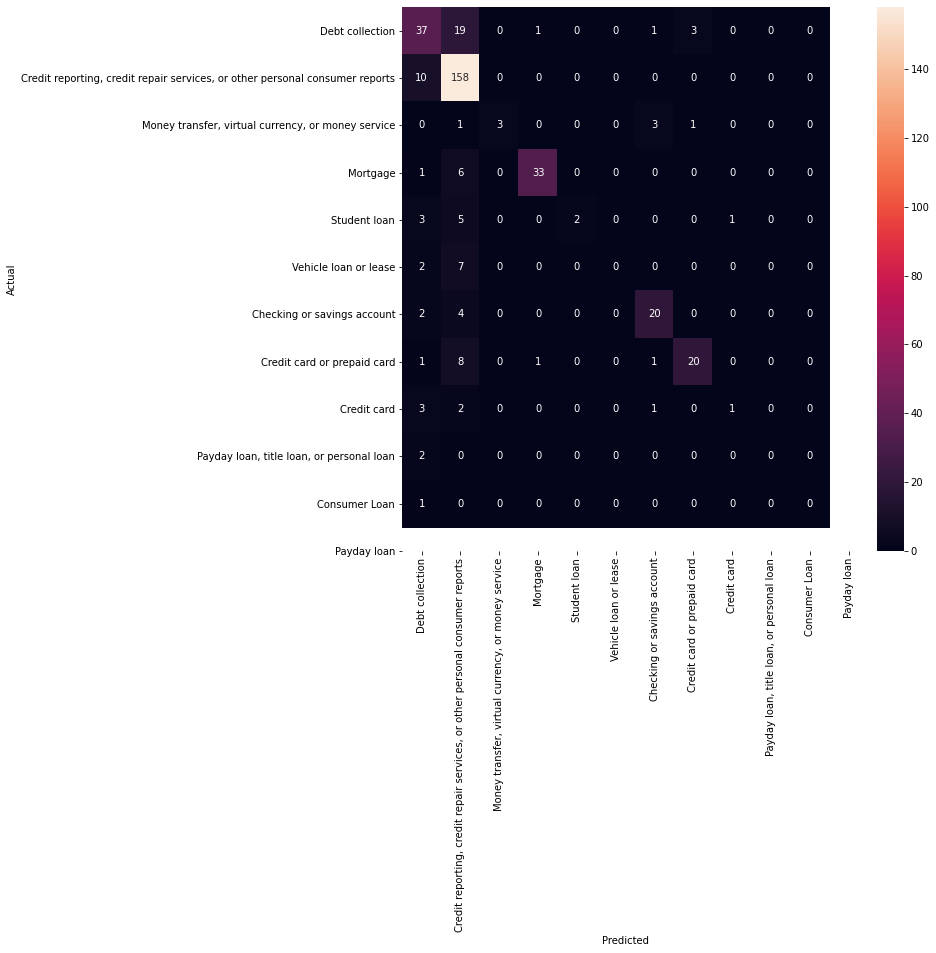

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# BERT :D

In [167]:
!pip install bert-tensorflow

    100% |████████████████████████████████| 71kB 843kB/s ta 0:00:011
